Processing 6.jpg


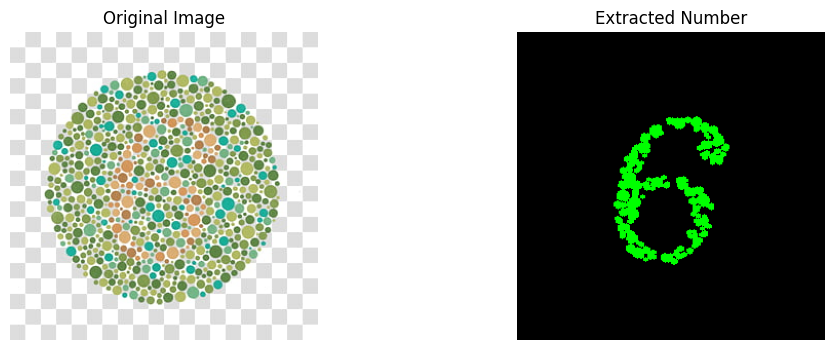

Processing 12.jpg


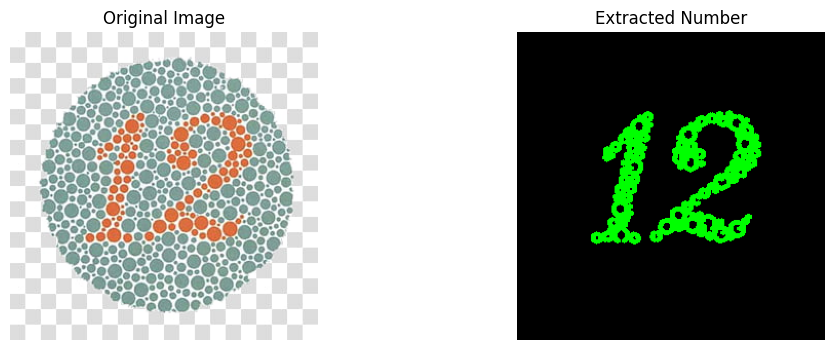

Processing 42.jpg


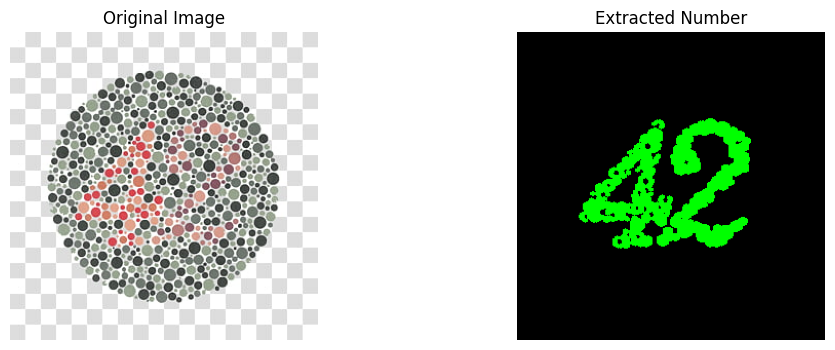

Processing 74.jpg


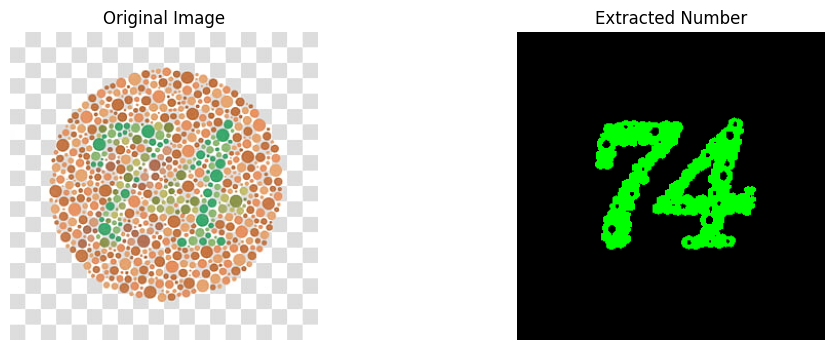

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def initialize_centroids_kmeanspp(data, k, random_state=42):
    """Initialize centroids using k-means++ algorithm."""
    np.random.seed(random_state)
    n_samples = data.shape[0]

    # Choose first centroid randomly
    indices = np.random.choice(n_samples, 1, replace=False)
    centroids = data[indices].copy()

    # Choose remaining centroids
    for _ in range(k - 1):
        distances = np.minimum.reduce([np.sum((data - c) ** 2, axis=1) for c in centroids])
        probs = distances / distances.sum()
        next_centroid_idx = np.random.choice(n_samples, 1, p=probs)
        centroids = np.vstack([centroids, data[next_centroid_idx]])

    return centroids

def custom_kmeans(data, k, random_state=42, max_iterations=300, tol=1e-4):
    """
    Custom K-means clustering implementation with optimized vectorized operations.
    Args:
        data: Input data (n_samples, n_features)
        k: Number of clusters
        random_state: Seed for reproducibility
        max_iterations: Maximum number of iterations
        tol: Tolerance for convergence
    Returns:
        labels: Cluster assignments for each data point
        centroids: Final centroids
    """
    np.random.seed(random_state)
    n_samples, n_features = data.shape

    # Initialize centroids using k-means++
    centroids = initialize_centroids_kmeanspp(data, k, random_state)

    for iteration in range(max_iterations):
        # Compute distances using vectorized operations
        distances = np.sqrt(np.sum((data[:, np.newaxis] - centroids) ** 2, axis=2))

        # Assign labels using vectorized argmin
        labels = np.argmin(distances, axis=1)

        # Store old centroids for convergence check
        old_centroids = centroids.copy()

        # Update centroids using vectorized mean
        for i in range(k):
            mask = (labels == i)
            points_in_cluster = data[mask]
            if len(points_in_cluster) > 0:
                centroids[i] = np.mean(points_in_cluster, axis=0)
            else:
                # Reassign empty cluster to a random point
                centroids[i] = data[np.random.choice(n_samples)]

        # Check for convergence
        if np.all(np.abs(centroids - old_centroids) < tol):
            break

    return labels, centroids

def process_ishihara(image_path):
    # Read the image
    image = cv2.imread(image_path)

    # Convert to Lab color space
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Extract 'a' channel (red-green component)
    a_channel = lab_image[:, :, 1]

    # Set parameters based on image
    if image_path == '6.jpg':
        k = 26
        target_cluster = 25
    elif image_path == '12.jpg':
        k = 10
        target_cluster = 6
    elif image_path == '42.jpg':
        k = 5
        target_cluster = 2
    else:  # 74.jpg
        k = 5
        target_cluster = 4

    # Reshape the channel for clustering
    pixel_values = a_channel.reshape((-1, 1)).astype(np.float64)

    # Perform custom k-means clustering
    labels, centroids = custom_kmeans(pixel_values, k, random_state=42)

    # Reshape labels back to original image dimensions
    labels = labels.reshape(a_channel.shape)

    # Create binary mask for the target cluster
    mask = (labels == target_cluster).astype(np.uint8)

    # Apply morphological operations to fill the dots
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    mask = cv2.dilate(mask, kernel, iterations=1)

    # Create output image (black background)
    output = np.zeros_like(image)

    # Set the pixels of the target cluster to bright green
    output[mask == 1] = [0, 255, 0]

    # Ensure the green is fully saturated
    output = cv2.convertScaleAbs(output, alpha=1.2, beta=0)

    # Display results
    plt.figure(figsize=(12, 4))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Extracted number
    plt.subplot(1, 2, 2)
    plt.imshow(output)
    plt.title('Extracted Number')
    plt.axis('off')

    plt.show()

# Process each image
images = ['6.jpg', '12.jpg', '42.jpg', '74.jpg']

for img_path in images:
    print(f"Processing {img_path}")
    process_ishihara(img_path)